# Финальные результаты декомпозиции галактик

In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: QtAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import shutil
import pandas as pd
import tabulate
import numpy as np
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.ndimage import rotate
from astropy.io import fits as pyfits

from astropy.visualization import ZScaleInterval
import imfittools.make_slice as ms
import imfittools.ImfitModel as imfitmod

## Часть 1/3: сводная таблица
===========================================================================================================

In [4]:
# Сводная таблица
# -------------------
# names = [[name,fold,n_bulges, i_2_bulges, i_1_bulge], [...], ...]
# где name - имя галактики fold - hexagons и т.д., i_2_bulges - итерация, на которой 2 балджа (если совсем
# не используются оба балджа, то поставить число 0, если используются, то самая последняя итерация), i_1_bulge -
# итерация, на которой использовался или до сих пор используется 1 балдж (во втором случае это самая последняя
# итерация)
names = [['EON_150.398_-2.994','hexagons',4,2],
         ['732_72_0_line4676','iso_break',4,2],['2015_16_1_line2021','iso_break',0,3]]
    

table_data = [['Name','chi2_base','chi2_imfit_b1','chi2_imfit_b2', 
          'B/T_b1','(B/PS)/T_b2','B_cent/T_b2','Disk_b1','Disk_b2','D/T_b1','D/T_b2',
          'n_Sers_b1','n_Sers_bps_b2','n_Sers_bcent_b2']]

for i in range(0,len(names)):
    path_raw = '../data/small_samp/{}/{}/image.fits'.format(names[i][1], names[i][0])
    hdulist_raw  = pyfits.open(path_raw)
    data_raw = hdulist_raw[0].data
    path_base_model = '../data/images/{}/{}/model_r_rotcrop.fits'.format(names[i][1], names[i][0])
    hdulist_base_model = pyfits.open(path_base_model)
    data_base_model = hdulist_base_model[0].data
    names_loc = os.listdir('../data/small_samp/{}/{}'.format(names[i][1], names[i][0]))
    for name in names_loc:
        if names[i][2] != 0:
            if name.find('comps_prec{}_2_'.format(names[i][2])) != -1:
                path_imfit_model_disk_2 = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0],name)
                hdulist_imfit_model_disk_2  = pyfits.open(path_imfit_model_disk_2)
                data_imfit_model_disk_2 = hdulist_imfit_model_disk_2[0].data
            if name.find('comps_prec{}_Sersics'.format(names[i][2])) != -1:
                path_imfit_model_bulge_2 = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0],name)
                hdulist_imfit_model_bulge_2  = pyfits.open(path_imfit_model_bulge_2)
                data_imfit_model_bulge_2 = hdulist_imfit_model_bulge_2[0].data  
        if name.find('comps_prec{}_2_'.format(names[i][3])) != -1:
            path_imfit_model_disk_1 = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0],name)
            hdulist_imfit_model_disk_1  = pyfits.open(path_imfit_model_disk_1)
            data_imfit_model_disk_1 = hdulist_imfit_model_disk_1[0].data
        if name.find('comps_prec{}_1_Sersic'.format(names[i][3])) != -1:
            path_imfit_model_bulge_1 = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0],name)
            hdulist_imfit_model_bulge_1  = pyfits.open(path_imfit_model_bulge_1)
            data_imfit_model_bulge_1 = hdulist_imfit_model_bulge_1[0].data     
    path_invvarmap = '../data/small_samp/{}/{}/invarmap/invvar_r_rotcrop.fits'.format(names[i][1], names[i][0])
    hdulist_invvarmap = pyfits.open(path_invvarmap)
    data_invvarmap = hdulist_invvarmap[0].data
    path_flux_b1 = '../data/small_samp/{}/{}/fluxes{}.dat'.format(names[i][1],names[i][0],names[i][3])
    path_bestfit_b1 = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(names[i][1],names[i][0],names[i][3])
    path_bestfit_b2 = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(names[i][1],names[i][0],names[i][2])
    
    chi2_base = sum(data_invvarmap*(data_base_model - data_raw)**2)
    chi2_imfit_b1 = sum(data_invvarmap*(data_imfit_model_disk_1 + data_imfit_model_bulge_1 - data_raw)**2)
    chi2_imfit_b2 = None
    if names[i][2] != 0:
        chi2_imfit_b2 = sum(data_invvarmap*(data_imfit_model_disk_2 + data_imfit_model_bulge_2 - data_raw)**2)
        path_flux_b2 = '../data/small_samp/{}/{}/fluxes{}.dat'.format(names[i][1],names[i][0],names[i][2])
                
    sers1 = 0
    with open(path_flux_b1) as file:
        for l in file:
            if sers1 == 0:
                if l.find('Sersic') != -1:
                    bps_t_b1 = float(l.split()[3])
                    sers1 = 1
                    continue
                continue
            if sers1 == 1:
                disk1 = l.split()[0]
                if disk1.find('BknExp3D') != -1:
                    disk_type_b1 = 'BknExp3D'
                if disk1.find('ExponentialDisk3D') != -1:
                    disk_type_b1 = 'Exp3D'
                d_t_b1 = float(l.split()[3])
                sers1 = 2
                break 
    bps_t_b2 = None
    bc_t_b2 = None
    d_t_b2 = None
    disk_type_b2 = None
    if names[i][2] != 0:
        sers2 = 0
        with open(path_flux_b2) as file:
            for l in file:
                if sers2 == 0:
                    if l.find('Sersic') != -1:
                        bps_t_b2 = float(l.split()[3])
                        sers2 = 1
                        continue
                    continue
                if sers2 == 1:
                    disk2 = l.split()[0]
                    if disk2.find('BknExp3D') != -1:
                        disk_type_b2 = 'BknExp3D'
                    if disk2.find('ExponentialDisk3D') != -1:
                        disk_type_b2 = 'Exp3D'
                    d_t_b2 = float(l.split()[3])
                    sers2 = 2
                    continue
                if sers2 == 2:
                    if l.find('Sersic') != -1:
                        bc_t_b2 = float(l.split()[3])
                        sers2 = 3
                    break
    
    with open(path_bestfit_b1) as file:
        for line in file:
            try:
                if line.split()[0] == 'n':
                    n_sersic_b1 = float(line.split()[1])
                    break
            except:
                continue
    n_sersic_bps_b2 = None
    n_sersic_bc_b2 = None
    if names[i][2] != 0:
        sersic_flag = 0
        with open(path_bestfit_b2) as file:
            for line in file:
                try:
                    if line.split()[0] == 'n':
                        sersic_flag += 1
                        if sersic_flag == 1:
                            n_sersic_bps_b2 = float(line.split()[1])
                        if sersic_flag == 3:
                            n_sersic_bc_b2 = float(line.split()[1])
                            break
                except:
                    continue
    
    table_data.append([names[i][0],chi2_base,chi2_imfit_b1,chi2_imfit_b2,bps_t_b1,bps_t_b2,bc_t_b2,
                  disk_type_b1,disk_type_b2,d_t_b1,d_t_b2,n_sersic_b1,n_sersic_bps_b2,n_sersic_bc_b2])
    
table = tabulate.tabulate(table_data, tablefmt='html')
print('chi2_base - хи-квадрат для вычета с Легаси')
print('chi2_imfit_b1 - хи-квадрат для нашего вычета (модель с одним балджем)')
print('chi2_imfit_b2 - хи-квадрат для нашего вычета (модель с двумя балджами)')
print('B/T_b1 - отношение интенсивности балджа к общей (модель с одним балджем)')
print('(B/PS)/T_b2 - отношение интенсивности B/PS-балджа к общей (модель с двумя балджами)')
print('B_cent/T_b2 - отношение интенсивности центрального яркого балджа к общей (модель с двумя балджами)')
print('Disk_b1, Disk_b2 - тип диска (модель с одним и двумя балджами соответственно)')
print('D/T_b1, D/T_b2 - отношение интенс-ти диска к общей (модель с одним и двумя балджами соответственно)')
print('n_Sers_b1 - параметр Серсика (модель с одним балджем)')
print('n_Sers_bps_b2 - параметр Серсика для B/PS-балджа (модель с двумя балджами)')
print('n_Sers_bcent_b2 - параметр Серсика для центрального яркого балджа (модель с двумя балджами)')
print('-'*10)
print('Пустые позиции означают, что такой модели нет. Например, если нет модели с двумя балджами, то на')
print('позициях с _b2 будет пусто')
table 

chi2_base - хи-квадрат для вычета с Легаси
chi2_imfit_b1 - хи-квадрат для нашего вычета (модель с одним балджем)
chi2_imfit_b2 - хи-квадрат для нашего вычета (модель с двумя балджами)
B/T_b1 - отношение интенсивности балджа к общей (модель с одним балджем)
(B/PS)/T_b2 - отношение интенсивности B/PS-балджа к общей (модель с двумя балджами)
B_cent/T_b2 - отношение интенсивности центрального яркого балджа к общей (модель с двумя балджами)
Disk_b1, Disk_b2 - тип диска (модель с одним и двумя балджами соответственно)
D/T_b1, D/T_b2 - отношение интенс-ти диска к общей (модель с одним и двумя балджами соответственно)
n_Sers_b1 - параметр Серсика (модель с одним балджем)
n_Sers_bps_b2 - параметр Серсика для B/PS-балджа (модель с двумя балджами)
n_Sers_bcent_b2 - параметр Серсика для центрального яркого балджа (модель с двумя балджами)
----------
Пустые позиции означают, что такой модели нет. Например, если нет модели с двумя балджами, то на
позициях с _b2 будет пусто


Name,chi2_base,chi2_imfit_b1,chi2_imfit_b2,B/T_b1,(B/PS)/T_b2,B_cent/T_b2,Disk_b1,Disk_b2,D/T_b1,D/T_b2,n_Sers_b1,n_Sers_bps_b2,n_Sers_bcent_b2
EON_150.398_-2.994,694513.375,1806032.0,1787160.25,0.39745,0.31225,0.13983,BknExp3D,BknExp3D,0.60255,0.54792,2.03883,1.0,4.80045
732_72_0_line4676,1794640.0,27281146.0,27460998.0,0.41452,0.21984,0.13052,BknExp3D,BknExp3D,0.58548,0.64964,2.50032,1.0,4.5
2015_16_1_line2021,217488.65625,417249.90625,,0.45452,,,BknExp3D,,0.54548,,1.98086,,


## Часть 2/3: декомпозиция
===========================================================================================================

In [10]:
file_all_gal = 'voting_with_coords.csv'
df_all_gal = pd.read_csv('../data/{}'.format(file_all_gal), header=None)
# Получаем индекс галактики в voting_with_coords.csv, чтобы по индексу можно было получить ra,dec
def getind_gal(name_gal,df):
    for i in arange(1,df.shape[0]):
        if name_gal == df[0][i]:
            return i 
            break

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
hexagons
EON_150.398_-2.994
 
Simbad:
http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=150.397629d-2.994423d&CooFrame=ICRS&CooEpoch=2000&CooEqui=2000&Radius=0.5&Radius.unit=arcmin&submit=submit+query&CoordList=
NED:
https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates=150.397629d%20-2.994423d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center
Legacy:
https://www.legacysurvey.org/viewer/?ra=150.397629&dec=-2.994423&layer=ls-dr9&zoom=13


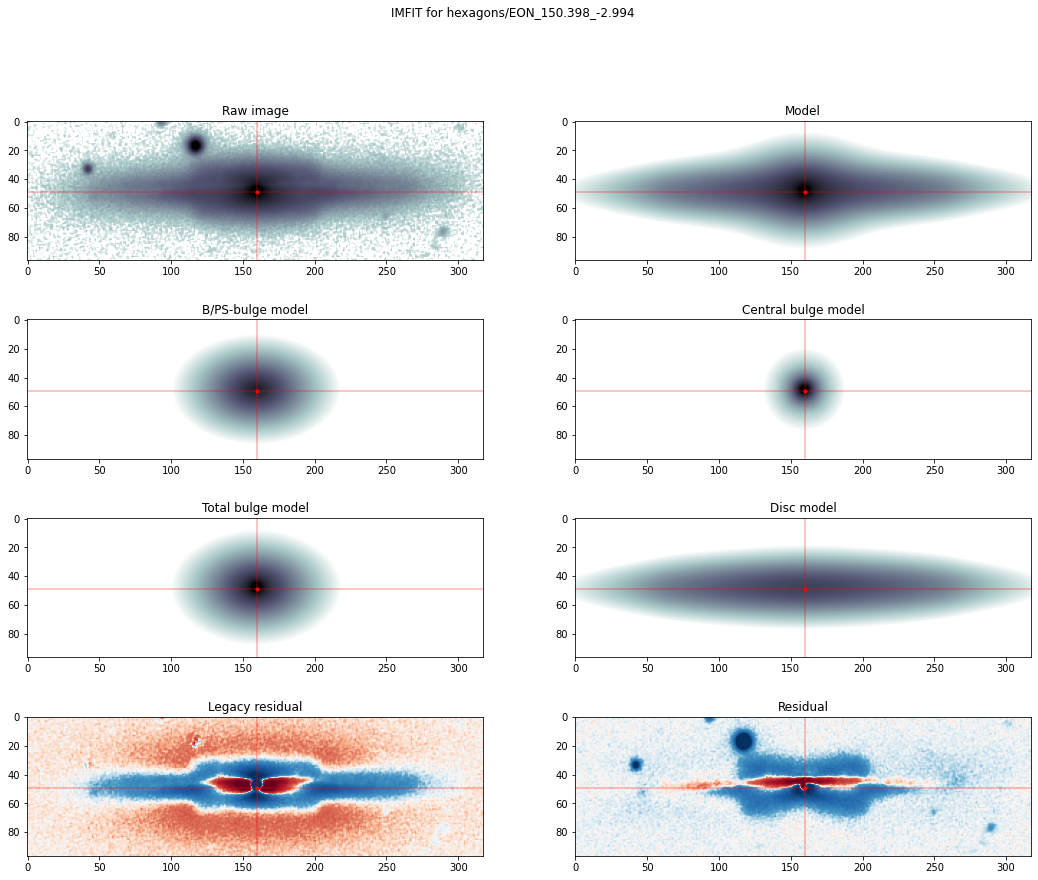

Reading '../data/small_samp/hexagons/EON_150.398_-2.994/bestfit4.imfit':
  3 functions found (24 parameters)

Biggest component of a model is BknExp3D.1
It's coordinates 160.0,49.2.
It's position angle 89.7744
Making model


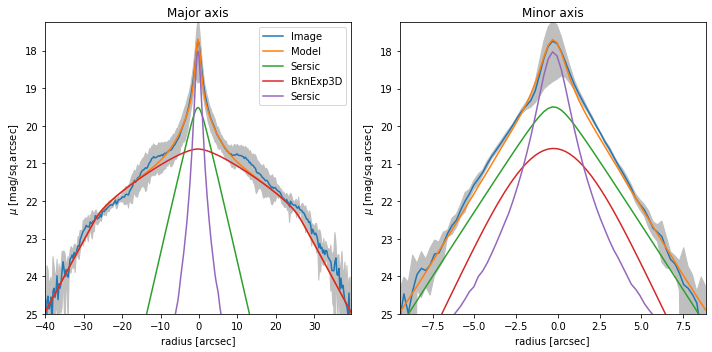

           ----------------------------------------------------------------------
           Config                                               Bestfit
 
X0 160.0 fixed                                      #   Best-fit value: 174407.080469
Y0 49.2 fixed                                       #   Reduced value: 5.735000
FUNCTION Sersic                                     #   AIC: 174437.096254
PA 90 fixed                                         #   BIC: 174561.926261
ell 0.4 0,0.8                                       
n 1 fixed                                           X0		160.0000 # +/- 0.0000
I_e 0.32787 0.10969675,3.995148                     Y0		49.2000 # +/- 0.0000
r_e 17.0724 2.0181,32.2896                          FUNCTION Sersic
FUNCTION BknExp3D                                   PA		     90 # +/- 0
PA 89.8501 87.8501,91.8501                          ell		0.361527 # +/- 0.0032032
inc 82.8538 75,105                                  n		      1 # +/- 0
J_0 0.0081127 0.00085635,0.

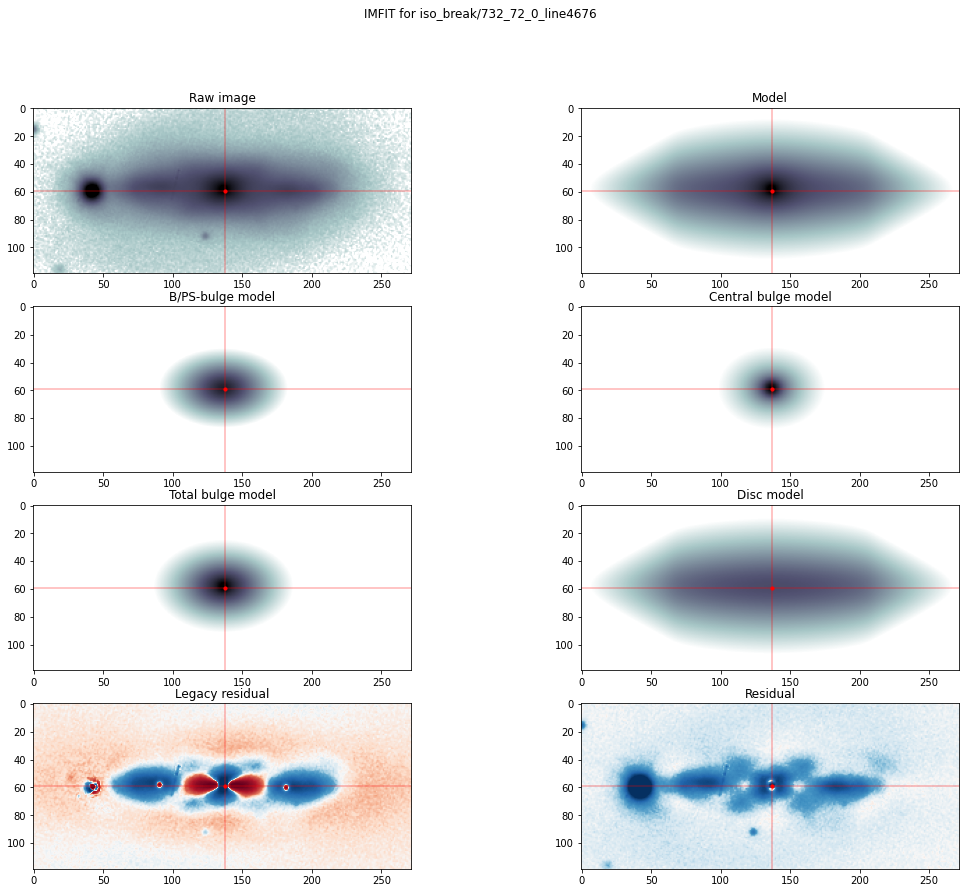

Reading '../data/small_samp/iso_break/732_72_0_line4676/bestfit4.imfit':
  3 functions found (24 parameters)

Biggest component of a model is BknExp3D.1
It's coordinates 137.2,59.3.
It's position angle 90.098
Making model


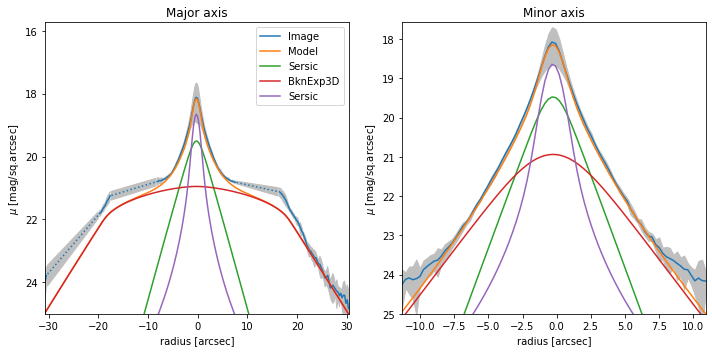

           ----------------------------------------------------------------------
           Config                                               Bestfit
 
X0 137.25 fixed                                     #   Best-fit value: 179651.710969
Y0 59.3 fixed                                       #   Reduced value: 5.956227
FUNCTION Sersic                                     #   AIC: 179679.724894
PA 90 fixed                                         #   BIC: 179796.118200
ell 0.5 0,0.8                                       
n 1 fixed                                           X0		137.2500 # +/- 0.0000
I_e 0.24556 0.0176035,1.241656                      Y0		59.3000 # +/- 0.0000
r_e 16.8988 5.743675,25.8988                        FUNCTION Sersic
FUNCTION BknExp3D                                   PA		     90 # +/- 0
PA 89.9214 87.9214,91.9214                          ell		0.390514 # +/- 0.0013465
inc 90 80,100                                       n		      1 # +/- 0
J_0 0.00397338 0.00103695,0

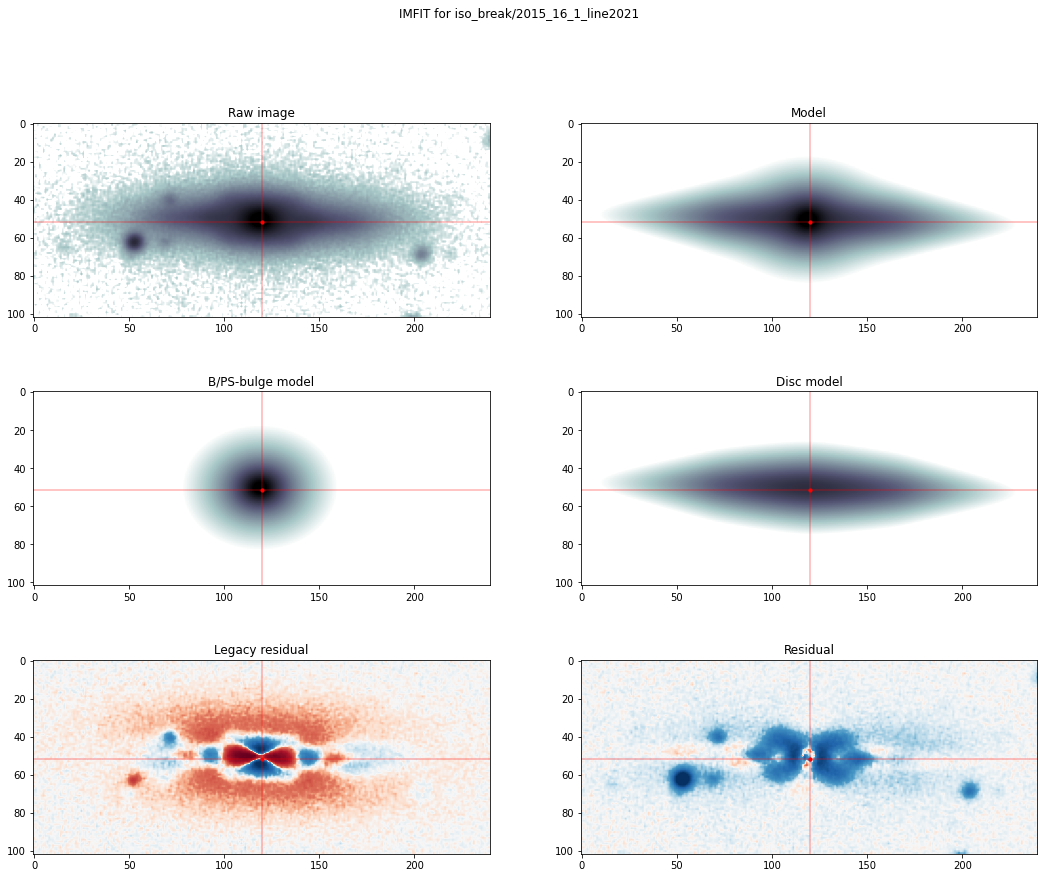

Reading '../data/small_samp/iso_break/2015_16_1_line2021/bestfit3.imfit':
  2 functions found (17 parameters)

Biggest component of a model is BknExp3D.1
It's coordinates 119.7,51.6.
It's position angle 91.434
Making model


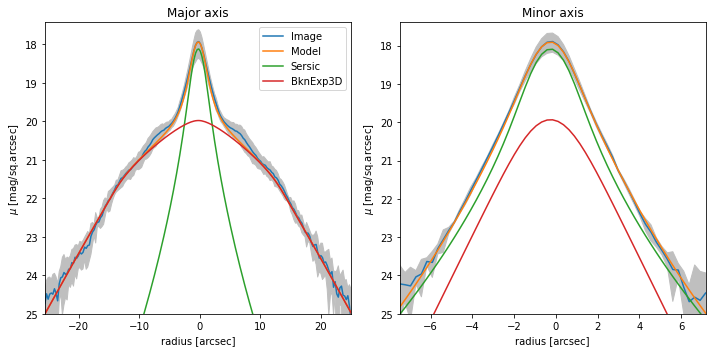

           ----------------------------------------------------------------------
           Config                                               Bestfit
 
X0 119.8 fixed                                      #   Best-fit value: 31.601377
Y0 51.6 fixed                                       #   Reduced value: 0.001322
FUNCTION Sersic                                     #   AIC: 55.614434
PA 90.0 88.0,92.0                                   #   BIC: 152.584998
ell 0.251302 0,0.5                                  
n 2.05286 0.5,8.0                                   X0		119.70000 # +/- 0.0000
I_e 1.58685 0.3967125,6.3474                        Y0		51.6000 # +/- 0.0000
r_e 4.64828 1.16207,18.59312                        FUNCTION Sersic
FUNCTION BknExp3D                                   PA		    90 # +/- 0
PA 91.434 89.434,93.434                             ell		0.201302 # +/- 0.12336
inc 79.3928 80,90                                   n		1.98086 # +/- 0.62728
J_0 0.0433736 0.0216868,0.0867472 

In [23]:
#names = [[name,fold,iter,n_bulges],[...], ...]
# name - имя, fold - группа, iter - итерация подгонки, n_bulges - кол-во модельных балджей (либо 1, либо 2)
# ----------------------
names = [['EON_150.398_-2.994','hexagons',4,2],['732_72_0_line4676','iso_break',4,2],
         ['2015_16_1_line2021','iso_break',3,1]]
#names = [['2015_16_1_line2021','iso_break',3,1]]

for i in range(len(names)):
    print('=*'*50)
    print(names[i][1])
    print(names[i][0])
    
        # Дадим некоторые ссылки на галактику        
    ind_gal = getind_gal(names[i][0],df_all_gal)
    ra = float(df_all_gal[1][ind_gal])
    dec = float(df_all_gal[2][ind_gal])
    url_simbad = "http://simbad.u-strasbg.fr/simbad/sim-coo?Coord={}d{}d&CooFrame=ICRS&CooEpoch=2000&CooEqui=2000&Radius=0.5&Radius.unit=arcmin&submit=submit+query&CoordList=".format(ra,dec)
    ra_ned = round(ra, 10)
    dec_ned = round(dec, 10)
    if dec>0.0:
        url_ned = "https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates={}d%20%2B{}d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center".format(ra_ned,dec_ned)
    else:
        url_ned = "https://ned.ipac.caltech.edu/conesearch?in_csys=Equatorial&in_equinox=J2000&coordinates={}d%20{}d&radius=0.2&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1&z_constraint=Unconstrained&z_unit=z&ot_include=ANY&nmp_op=ANY&search_type=Near%20Position%20Search&out_csys=Equatorial&out_equinox=Same%20as%20Input&obj_sort=Distance%20to%20search%20center".format(ra_ned,dec_ned)

    url_legacy = "https://www.legacysurvey.org/viewer/?ra={}&dec={}&layer=ls-dr9&zoom=13".format(ra,dec)
    print(" ")
    print("Simbad:")
    print(url_simbad)
    print("NED:")
    print(url_ned)
    print("Legacy:")
    print(url_legacy)
    
        # Разберёмся со всеми путями -------------------
    path_raw = '../data/small_samp/{}/{}/image.fits'.format(names[i][1],names[i][0])
    path_base_resid = '../data/images/{}/{}/residual_r_rotcrop.fits'.format(names[i][1],names[i][0])
    path_imfit_resid = '../data/small_samp/{}/{}/residual{}.fits'.format(names[i][1],names[i][0],names[i][2])
    names_loc = os.listdir('../data/small_samp/{}/{}'.format(names[i][1],names[i][0]))
    for name in names_loc:
        if name.find('comps_prec{}_1_Sersic'.format(names[i][2])) != -1:
            path_imfit_model_bps =  '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0], name)
        if names[i][3] == 2:
            if name.find('comps_prec{}_3_Sersic'.format(names[i][2])) != -1:
                path_imfit_model_bcent =  '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0], name)
            if name.find('comps_prec{}_Sersics'.format(names[i][2])) != -1:
                path_imfit_model_bulge =  '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0], name)
        if name.find('comps_prec{}_2_'.format(names[i][2])) != -1:
            path_imfit_model_disk = '../data/small_samp/{}/{}/{}'.format(names[i][1],names[i][0], name)
    path_imfit_model = '../data/small_samp/{}/{}/modelimage{}.fits'.format(names[i][1],names[i][0],names[i][2])
    path_bestfit = '../data/small_samp/{}/{}/bestfit{}.imfit'.format(names[i][1],names[i][0],names[i][2])
    path_config = '../data/small_samp/{}/{}/config{}.imfit'.format(names[i][1],names[i][0],names[i][2])
    path_psf = '../data/small_samp/{}/{}/psf.fits'.format(names[i][1],names[i][0])
    path_mask = '../data/small_samp/{}/{}/mask{}.fits'.format(names[i][1],names[i][0],names[i][2])
    path_decomp = '../data/small_samp/{}/{}/picture_final.png'.format(names[i][1],names[i][0])
    path_slice = '../data/small_samp/{}/{}/slice{}.png'.format(names[i][1],names[i][0],names[i][2])
            
            
        # Открытие фитсов
    hdulist_raw  = pyfits.open(path_raw)
    data_raw = hdulist_raw[0].data
    hdulist_base_resid  = pyfits.open(path_base_resid)
    data_base_resid = hdulist_base_resid[0].data
    hdulist_imfit_resid  = pyfits.open(path_imfit_resid)
    data_imfit_resid = hdulist_imfit_resid[0].data
    hdulist_imfit_model_bps  = pyfits.open(path_imfit_model_bps)
    data_imfit_model_bps = hdulist_imfit_model_bps[0].data
    if names[i][3] == 2:
        hdulist_imfit_model_bcent  = pyfits.open(path_imfit_model_bcent)
        data_imfit_model_bcent = hdulist_imfit_model_bcent[0].data
        hdulist_imfit_model_bulge  = pyfits.open(path_imfit_model_bulge)
        data_imfit_model_bulge = hdulist_imfit_model_bulge[0].data
    hdulist_imfit_model_disk  = pyfits.open(path_imfit_model_disk)
    data_imfit_model_disk = hdulist_imfit_model_disk[0].data
    hdulist_imfit_model = pyfits.open(path_imfit_model)
    data_imfit_model = hdulist_imfit_model[0].data
    
        # Считаем координаты центра из bestfit'а
    with open(path_bestfit) as file:
        for line in file:
            if line.find('X0') != -1:
                XCEN = float(line.split()[1])
            if line.find('Y0') != -1:
                YCEN = float(line.split()[1]) 
                
        # Начнём рисовать
        
    fig = plt.figure(figsize=[18,14])
    
    if names[i][3] == 2:
        n_str = 4
    else:
        n_str = 3

    plt.subplot(n_str, 2, 1) 
    plt.imshow(data_raw, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
    plt.scatter(XCEN,YCEN, 10, color='r')
    plt.axvline(x=XCEN,color='r', alpha=0.3)
    plt.axhline(y=YCEN,color='r', alpha=0.3)
    plt.title('Raw image')

    plt.subplot(n_str, 2, 2)
    plt.imshow(data_imfit_model, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
    plt.scatter(XCEN,YCEN, 10, color='r')
    plt.axvline(x=XCEN,color='r', alpha=0.3)
    plt.axhline(y=YCEN,color='r', alpha=0.3)
    plt.title('Model')

    plt.subplot(n_str, 2, 3)
    plt.imshow(data_imfit_model_bps, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
    plt.scatter(XCEN,YCEN, 10, color='r')
    plt.axvline(x=XCEN,color='r', alpha=0.3)
    plt.axhline(y=YCEN,color='r', alpha=0.3)
    plt.title('B/PS-bulge model')
    
    if names[i][3] == 2:
        plt.subplot(n_str, 2, 4)
        plt.imshow(data_imfit_model_bcent, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN,YCEN, 10, color='r')
        plt.axvline(x=XCEN,color='r', alpha=0.3)
        plt.axhline(y=YCEN,color='r', alpha=0.3)
        plt.title('Сentral bulge model')
        
        plt.subplot(n_str, 2, 5)
        plt.imshow(data_imfit_model_bulge, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
        plt.scatter(XCEN,YCEN, 10, color='r')
        plt.axvline(x=XCEN,color='r', alpha=0.3)
        plt.axhline(y=YCEN,color='r', alpha=0.3)
        plt.title('Total bulge model')
        
        n_d = 6
        n_leg_resid = 7
        n_imf_resid = 8
    else:
        n_d = 4
        n_leg_resid = 5
        n_imf_resid = 6

    plt.subplot(n_str, 2, n_d)
    plt.imshow(data_imfit_model_disk, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
    plt.scatter(XCEN,YCEN, 10, color='r')
    plt.axvline(x=XCEN,color='r', alpha=0.3)
    plt.axhline(y=YCEN,color='r', alpha=0.3)
    plt.title('Disc model')
    
    plt.subplot(n_str, 2, n_leg_resid)
    plt.imshow(data_base_resid, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
    plt.scatter(XCEN,YCEN, 10, color='r')
    plt.axvline(x=XCEN,color='r', alpha=0.3)
    plt.axhline(y=YCEN,color='r', alpha=0.3)
    plt.title('Legacy residual')

    plt.subplot(n_str, 2, n_imf_resid)
    plt.imshow(data_imfit_resid, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
    plt.scatter(XCEN,YCEN, 10, color='r')
    plt.axvline(x=XCEN,color='r', alpha=0.3)
    plt.axhline(y=YCEN,color='r', alpha=0.3)
    plt.title('Residual')
    
    plt.savefig(path_decomp,bbox_inches = 'tight', pad_inches = 0.1)#,dpi=400)     
    plt.suptitle(f'IMFIT for {names[i][1]}/{names[i][0]}')    
    plt.show()
    
        # Теперь сделаем горизонтальный и вертикальный срезы, нарисуем
    magzpt = 22.5
    image_scale = 0.262
    ms.make_slice(path_raw, path_bestfit, magzpt = magzpt, scale = image_scale, psf = path_psf, 
                                                         mask = path_mask, outname = path_slice)
    plt.show()
    
        # Выведем параметры из файлов

    with open(path_bestfit, 'r') as bf:
        bf_lines = bf.readlines()[7:]
    with open(path_config, 'r') as cf:
        cf_lines = cf.readlines()
    print("%s %s" %(' '*10, '-'*70))
    print("%s Config %s Bestfit" %(' '*10, ' '*45))
    print(' ')
    bcf = []
    bcf.append(len(cf_lines))
    bcf.append(len(bf_lines))
    for l in range(max(bcf)):
        try:
            lengb = len(cf_lines[l][:-1])
            print("%s %s %s" %(cf_lines[l][:-1], ' '*(50-lengb), bf_lines[l][:-1]))
        except:
            if bcf[0] == max(bcf):
                print("%s" %(cf_lines[l][:-1]))
            if bcf[1] == max(bcf):
                print("%s %s" %(' '*50, bf_lines[l][:-1]))
                

## Часть 3/3: срезы вдоль Х-структуры
===========================================================================================================

In [28]:
 # Функция для того, чтобы сделать срезы вдоль х-структуры
def slice_x(img, fig, i, n_str, xcen,ycen,angle1,angle2,leng):
   
      # Повернём изображение на один угол для одного среза, потом на другой для другого
    resid1 = rotate(img, angle=np.degrees(angle1), reshape=False)
    resid2 = rotate(img, angle=np.degrees(angle2), reshape=False)
      # Поворот был осуществлён относительно центра кадра, найдём этот центр
    cent_img_y = img.shape[0] / 2
    cent_img_x = img.shape[1] / 2
      # Найдём координаты центра "повёрнутой" галактики
    cent_gal_xr1, cent_gal_yr1 = rotate_coords(xcen, ycen, cent_img_x, cent_img_y, -angle1)
    cent_gal_xr2, cent_gal_yr2 = rotate_coords(xcen, ycen, cent_img_x, cent_img_y, -angle2)
      # Переведём в int
    cent_gal_xr1 = int(cent_gal_xr1)
    cent_gal_xr2 = int(cent_gal_xr2)
    cent_gal_yr1 = int(cent_gal_yr1)
    cent_gal_yr2 = int(cent_gal_yr2)
      # Сделаем срезы
    x_slice1 = resid1[cent_gal_yr1, cent_gal_xr1-int(leng/2):cent_gal_xr1+int(leng/2)]
    x_slice2 = resid2[cent_gal_yr2, cent_gal_xr2-int(leng/2):cent_gal_xr2+int(leng/2)]
      # Найдём координаты концов срезов на исходном, "неповёрнутом" изображении
    x11, y11 = rotate_coords(cent_gal_xr1-leng/2, cent_gal_yr1, cent_img_x, cent_img_y, angle1)
    x12, y12 = rotate_coords(cent_gal_xr1+leng/2, cent_gal_yr1, cent_img_x, cent_img_y, angle1)
    x21, y21 = rotate_coords(cent_gal_xr2-leng/2, cent_gal_yr2, cent_img_x, cent_img_y, angle2)
    x22, y22 = rotate_coords(cent_gal_xr2+leng/2, cent_gal_yr2, cent_img_x, cent_img_y, angle2)
      # Нарисуем эти срезы на исходном изображении
    plt.subplot(n_str, 2, i+1)
    plt.plot([x11, x12], [y11, y12], color = 'b')
    plt.plot([x21, x22], [y21, y22], color = 'orange')
      # Нарисуем сами срезы
    plt.subplot(n_str, 2, i+2)
    x_slice1 = resid1[cent_gal_yr1, cent_gal_xr1-int(leng/2):cent_gal_xr1+int(leng/2)]
    x_slice2 = resid2[cent_gal_yr2, cent_gal_xr2-int(leng/2):cent_gal_xr2+int(leng/2)]
    plt.plot(x_slice1, '.', color = 'b')
    plt.plot(x_slice2, '.', color = 'orange')
    plt.yscale('log')
    plt.title('Slices') 
 
 # Вспомогательная функция для slice_rotate()
def rotate_coords(x1, y1, xcen, ycen, angle):
    xrot = (x1 - xcen) * np.cos(angle) - (y1 - ycen) * np.sin(angle) + xcen
    yrot = (x1 - xcen) * np.sin(angle) + (y1 - ycen) * np.cos(angle) + ycen
    return xrot, yrot

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
hexagons
EON_150.398_-2.994


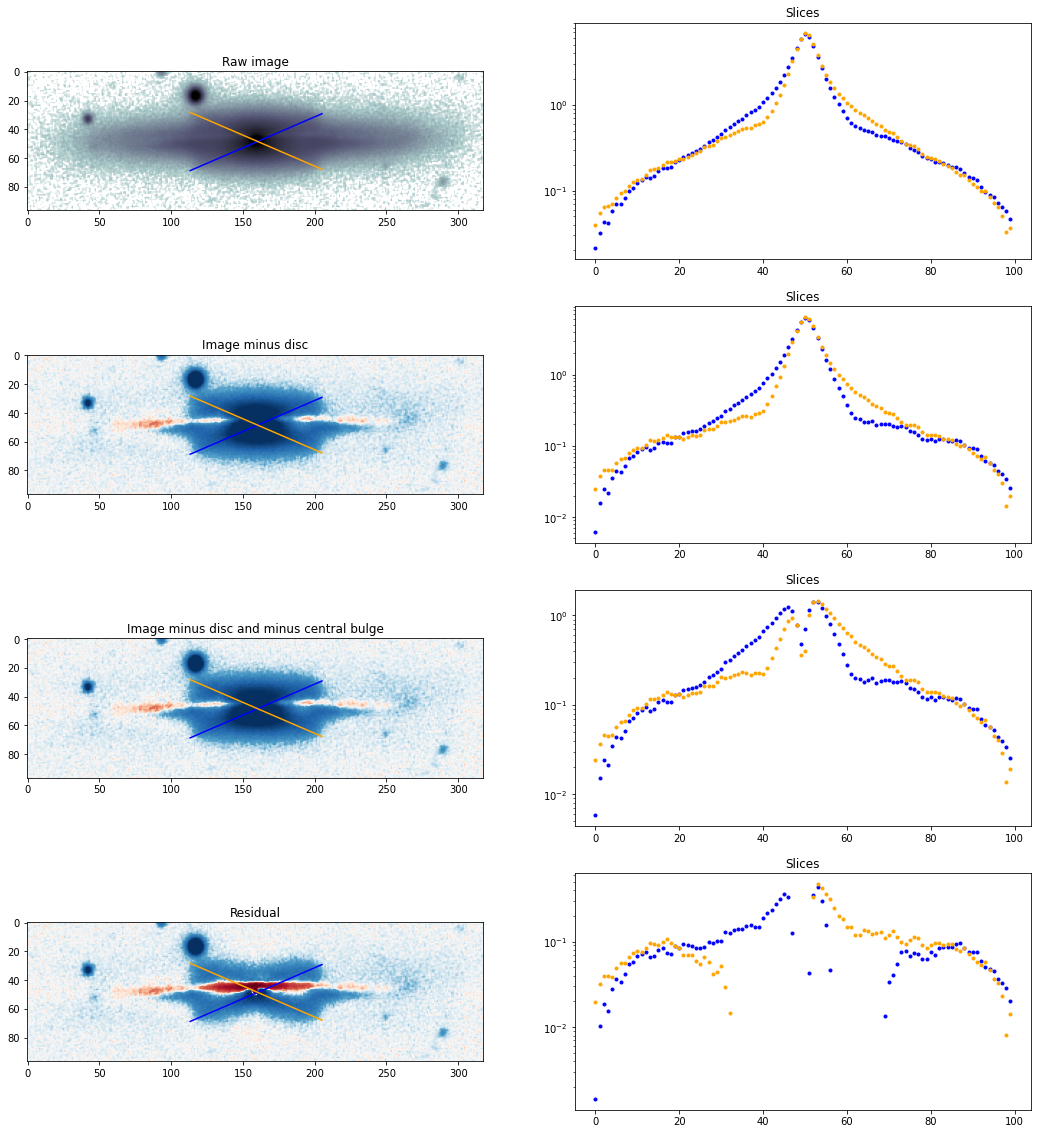

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iso_break
732_72_0_line4676


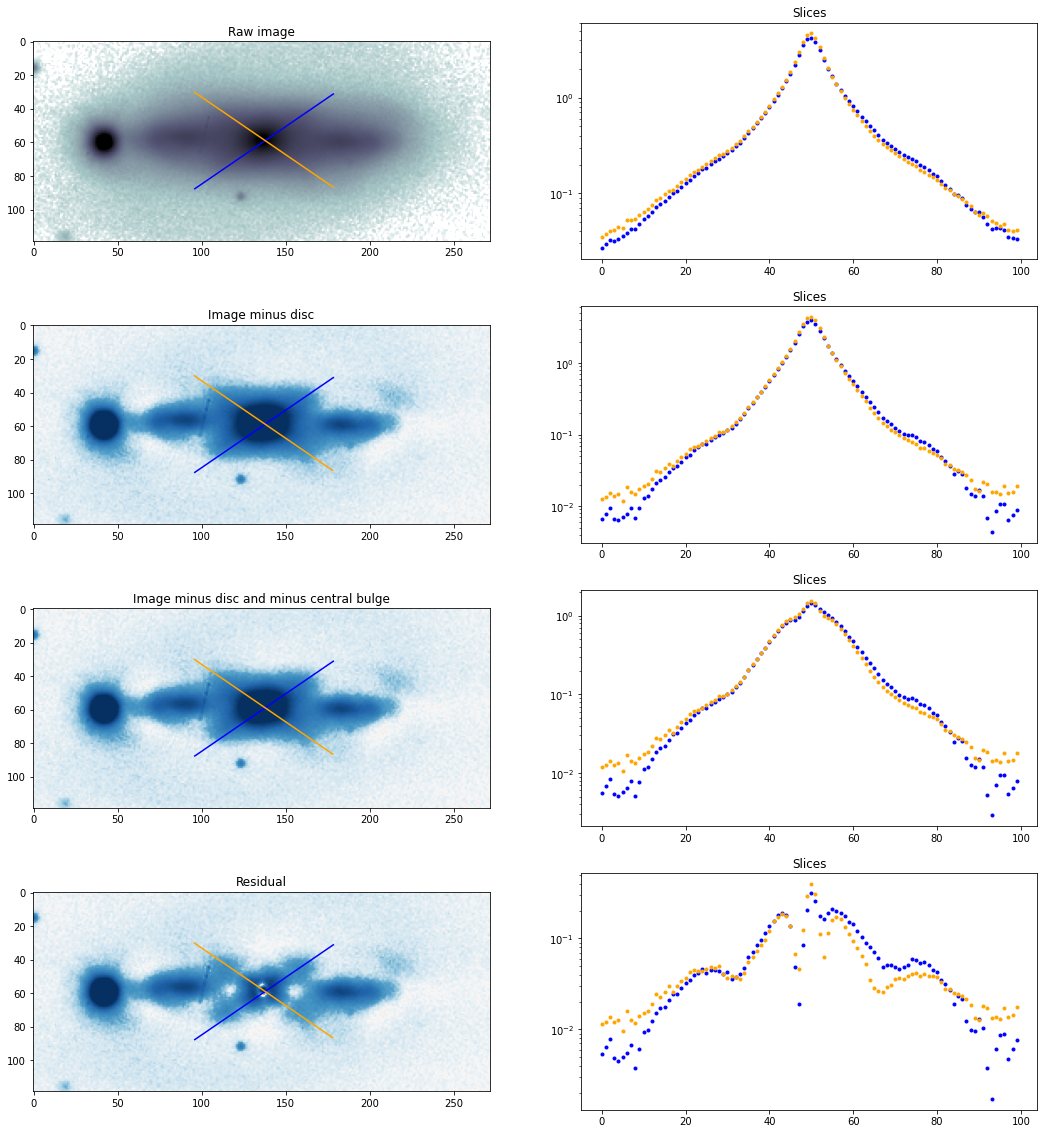

=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
iso_break
2015_16_1_line2021


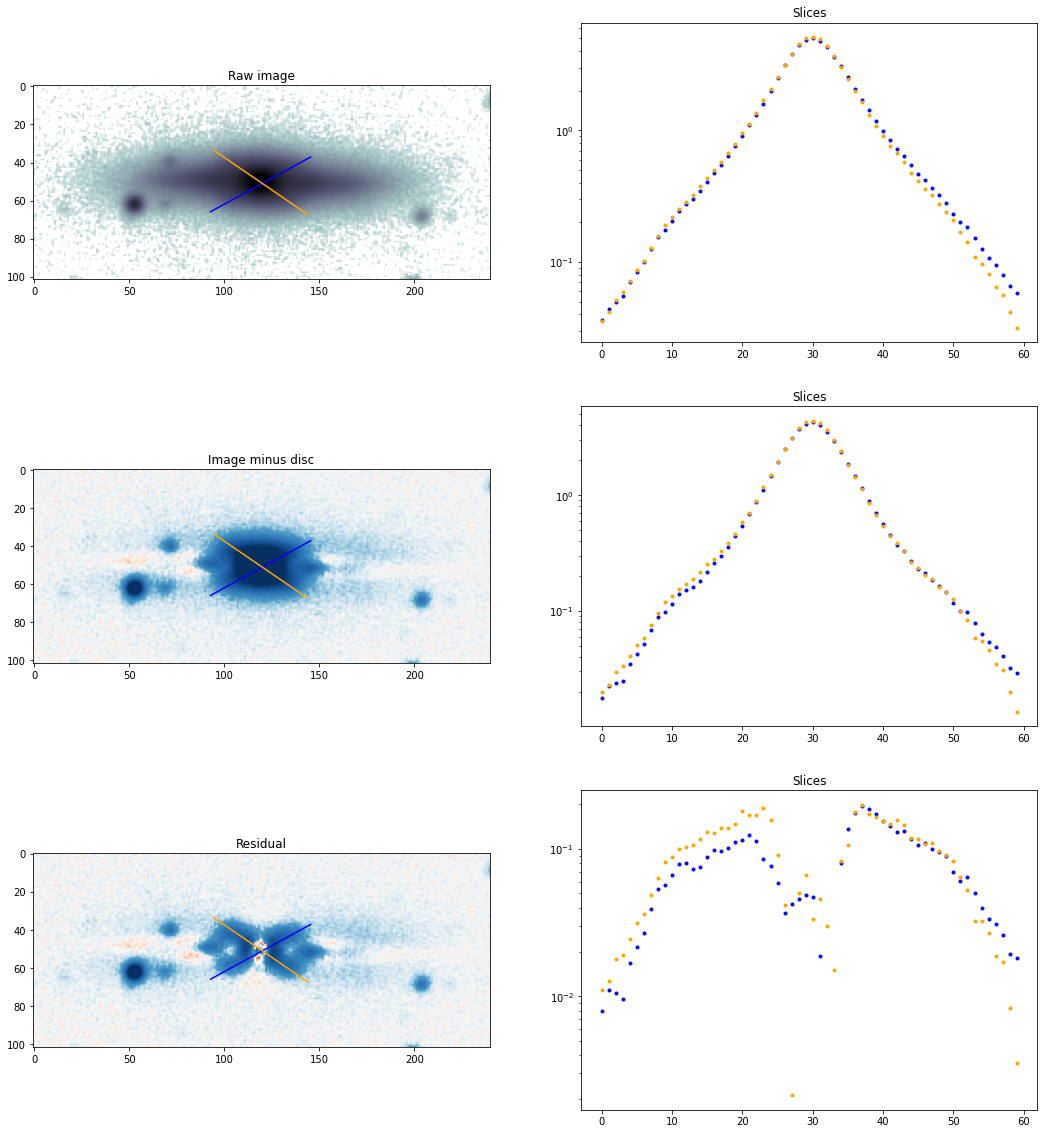

In [29]:
# names = [[name,fold,iter,n_bulges,cent_x,cent_y,angle1,angle2,leng],[...],....]
# -------------------------------------------------------------
#names = [['1237_50_0_line1676__EON_21.856_-1.913','hexagons',4,259,80.1,-0.607306,0.607306,100],
#         ['EON_150.398_-2.994','hexagons',4,160,48.7,-0.407306,0.407306,100],
#         ['732_72_0_line4676','iso_break',4,137.2,59.3,-0.60,0.60,100],
#         ['1720_93_1_line10922','iso_break',5,167.7,80.0,-0.50,0.50,110],
#         ['2015_16_1_line2021','iso_break',3,119.4,51.6,-0.50,0.60,60],
#         ['804_63_1_line2514','mass_bulge',3,92.07,33.99,-0.60,0.60,30],
#         ['1354_49_0_line6745','mass_bulge',4,141.3,59.0,-0.45,0.55,100],
#         ['1640_74_0_line13441','mass_bulge',3,97.7,47.0,-0.50,0.50,60],
#         ['2007_19_0_line21884','mass_bulge',4,145.3,72.7,-0.50,0.50,70],
#         ['EON_183.977_6.401','mass_bulge',3,227.7,98.5,-0.60,0.60,190]]
names = [['EON_150.398_-2.994','hexagons',4,2,160,48.7,-0.407306,0.407306,100],
         ['732_72_0_line4676','iso_break',4,2,137.2,59.3,-0.60,0.60,100],
         ['2015_16_1_line2021','iso_break',3,1,119.4,51.6,-0.50,0.60,60]]

for i in range(len(names)):
    print('=*'*50)
    print(names[i][1])
    print(names[i][0])

        # Пути
    path_raw = '../data/small_samp/{}/{}/image.fits'.format(names[i][1],names[i][0])
    path_raw_minus_disc = '../data/small_samp/{}/{}/image_minus_disc_{}.fits'.format(names[i][1],names[i][0],names[i][2])
    if names[i][3] == 2:
        path_bcent = '../data/small_samp/{}/{}/comps_prec{}_3_Sersic.fits'.format(names[i][1],names[i][0],names[i][2])
    path_resid = '../data/small_samp/{}/{}/residual{}.fits'.format(names[i][1],names[i][0],names[i][2])
    path_slice_x = '../data/small_samp/{}/{}/slice_x_final.png'.format(names[i][1],names[i][0])
    
        # Открытие файлов
    hdulist_raw  = pyfits.open(path_raw)
    data_raw = hdulist_raw[0].data
    hdulist_minus_disc = pyfits.open(path_raw_minus_disc) 
    data_minus_disc = hdulist_minus_disc[0].data
    if names[i][3] == 2:
        hdulist_bcent = pyfits.open(path_bcent) 
        data_bcent = hdulist_bcent[0].data 
        data_minus_d_bcent = data_minus_disc - data_bcent
    hdulist_resid  = pyfits.open(path_resid)
    data_resid = hdulist_resid[0].data
    
        # Рисование
    fig = plt.figure(figsize=[18,20])
    
    if names[i][3] == 2:
        n_str = 4
        n_bcent = 5
        n_res = 7
    else:
        n_str = 3
        n_res = 5
        
    plt.subplot(n_str, 2, 1)
    plt.imshow(data_raw, norm=LogNorm(vmin=0.003, vmax=3), cmap=cm.bone_r)
    plt.title('Raw image')  
    slice_x(data_raw, fig, 0, n_str, names[i][4], names[i][5], names[i][6], names[i][7], names[i][8])
    
    plt.subplot(n_str, 2, 3)
    plt.imshow(data_minus_disc, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
    plt.title('Image minus disc')  
    slice_x(data_minus_disc, fig, 2, n_str, names[i][4], names[i][5], names[i][6], names[i][7], names[i][8])
    
    if names[i][3] == 2:
        plt.subplot(n_str, 2, n_bcent)
        plt.imshow(data_minus_d_bcent, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
        plt.title('Image minus disc and minus central bulge')  
        slice_x(data_minus_d_bcent,fig,n_bcent-1,n_str,names[i][4],names[i][5],names[i][6],names[i][7],names[i][8])
    
    plt.subplot(n_str, 2, n_res)
    plt.imshow(data_resid, norm=SymLogNorm(linthresh=0.03, vmin=-0.3, vmax=0.3), cmap=cm.RdBu)
    plt.title('Residual')
    slice_x(data_resid,fig,n_res-1,n_str,names[i][4],names[i][5],names[i][6],names[i][7],names[i][8])
    
    plt.savefig(path_slice_x,bbox_inches = 'tight', pad_inches = 0.1)#,dpi=400)
    plt.show()
    